- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) with edits by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- **Date:** November 2024
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# fMRI Data Analysis: Region Of Interest (ROI) Analysis

Along with whole-brain analysis, it is common to perform region-of-interest (ROI) analysis on fMRI data. This involves extracting signals from specified ROIs. ROI analysis is valuable for several reasons, including **data exploration**, **statistical control**, and **functional specification**. For more information, see this brief review paper by R. Poldrack (2007): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2555436/.

ROIs can be defined based on brain structure or function. For **structural ROIs**, it is recommended to define them based on each subject's anatomy wherever possible. However, this is not always possible, or feasible. In such cases, one can use ROIs based on probabilistic or (less preferable) deterministic atlases. **Functional ROIs** can be defined from 'localiser' scans that identify specific regions exhibiting a particular response (e.g., 'face area' in the fusiform gyrus that respond more strongly to faces than to non-faces). Alternatively, functional ROIs can be defined using **independent contrasts** (make sure you don't do ['double dipping'](https://www.nature.com/articles/nn.2303)) within a factorial design or derived **from previous studies**.

In this tutorial, we demonstrate two common types of ROIs: a sphere around a peak voxel from a functional contrast, and an anatomical ROI from a probabilistic atlas.

1. **A spherical ROI** can help to average out noise and increase the reliability of the signal, as well as generalisability across studies. However, averaging across multiple voxels can reduce anatomical and functional specificity, potentially blurring the precise location of the activity.

2. **A probabilistic atlas** is commonly used when investigating brain regions that are functionally or anatomically well-characterised in the literature and show consistent properties across individuals. Using a probabilistic atlas allows for more straightforward comparisons between studies, as the ROIs are defined using the same criteria across different datasets. This enhances the reproducibility and comparability of results. Probabilistic atlases help reduce subjective decisions about where to place ROIs, thereby minimising experimenter bias. Unlike deterministic atlases (which are also commonly used), probabilistic atlases account for some variability in the exact location across subjects. However, they still represent an average across individuals, which might not fully capture the specific anatomy or function of a region in a particular subject. 

It is common, and often advisable, to perform **ROI analysis in a subject's native space** (using their original brain images without normalisation). Nonetheless, we will also provide an example of how to transform an MNI-space ROI to a subject's native space for native-space analysis.

---

**Table of contents**    
1. Import required packages and set up some stuff   
2. Load the subject-level fMRI results    
3. A single voxel ROI    
3.1. Function `extract_MNI_voxel_data`    
4. A spherical ROI  
4.1. Function `create_voxel_sphere`   
4.2. Function `create_MNIvoxel_sphere`   
4.3. Function `extract_mean_ROI_values`    
5. A ROI from a probabilistic atlas   
6. Transforming MNI-space ROI to native-space for native-space analysis    
7. Statistics and plotting of the ROI data    
7.1. Paired t-test: Initial vs Repeated Faces in the Right Fussiform Gyrus    
7.2. 3-way RM ANOVA. Initial vs Immediate Repetition vs Delayed Repetition in the Right Fusiform Gyrus    
7.2.1. A simple plot    
7.2.2. A 'publication-ready' plot    
7.3. 2-by-2 RM ANOVA. Repetition effect for Familiarity x Lag in the Right Fusiform Gurys    
7.4. Familiar vs Unfamiliar Faces in Amygdala    

-----
## Import required packages and set up some stuff

In [1]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 

import os
import os.path # for file path operations
import pandas  # for data manipulation
import numpy   # for numerical operations

# Plotting libraries
import seaborn # better looking plots
import matplotlib.pyplot as plt # basic plots
# to show plots in cell
%matplotlib inline   

# BIDS library
from bids.layout import BIDSLayout # to query BIDS dataset

# Stats libraries
from scipy import stats 
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Nilearn modules https://nilearn.github.io/
import nilearn
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_roi
from nilearn.image import resample_to_img, math_img
from nilearn.masking import _unmask_3d, compute_brain_mask
from nilearn.maskers import nifti_spheres_masker

import nibabel # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/
import ants    # ANTsPy (Advanced Normalization Tools), https://github.com/ANTsX/ANTsPy

wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
os.chdir(wd)
print(f"Working directory currently {os.getcwd()}")

Working directory currently /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing


In [2]:
# MNI152 template will be used as a backgound for plotting MNI-space ROIs
mni152_template = load_mni152_template() 
# Note that I could just use '= load_mni152_template()' but I want to easily see where the modules are coming from

## Load the subject-level fMRI results

In [3]:
# --- Set up the paths to the data and results folders
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

# --- Get all subject-level effect files for the specified conditions
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz')

# Print how many files there are to check if it is correct
nsub = len(layout.get_subjects())
ncond = len(conditions)
print(f"\nFound {len(effect_files)} files. Should be {nsub} subjects * {ncond} conditions = {nsub * ncond}\n")
# Print them for inspection
# print(*effect_files, sep="\n")


Found 144 files. Should be 16 subjects * 9 conditions = 144



Now we can use the function to extract the contrast values of the specified voxel from the subject-level results.

## A functional ROI from a sphere around functional peak (in right fusiform)

In this section, we use two functions. The first function calls NiLearn's `create_MNIvoxel_sphere` to create a mask image of voxels within a sphere of a certain radius (in mm) around coordinates that are provided, which should be in MNI-space (or another world-space). The second function, `extract_mean_ROI_values` is used to extract and compute the mean values across voxels within this ROI, for each of one or more fMRI images provided. 

### Define the spherical mask

In [4]:
def create_MNIvoxel_sphere(base_image, center_voxel, radius_mm):
    """
    Create a sphere mask based on the MNI coordinates and radius within the base_image.

    Parameters:
    - base_image (nibabel.Nifti1Image): A 3D Nifti1Image (in MNI space) that defines the space in which the sphere will be created.
    - center_voxel (tuple): The (x, y, z) coordinates of the center voxel, in MNI space.
    - radius_mm (float): Radius of the sphere in millimeters.

    Returns:
    - sphere_mask (nibabel.Nifti1Image): A Nifti1Image containing the sphere mask.
    """
    
    # Compute a brain mask using the povided base image
    space_defining_image = compute_brain_mask(base_image)

    # Apply mask and get affinity matrix
    _, A = nifti_spheres_masker._apply_mask_and_get_affinity(
        seeds=[center_voxel],  # in MNI space; can be a list of coordinates
        niimg=None,
        radius=radius_mm,
        allow_overlap=False, 
        mask_img=space_defining_image
    )

    # Unmask the sphere mask
    sphere_mask_data = _unmask_3d(
        X=A.toarray().flatten(), 
        mask=space_defining_image.get_fdata().astype(bool)
    )

    # Create a Nifti1Image for the sphere mask
    sphere_mask = nibabel.Nifti1Image(sphere_mask_data, space_defining_image.affine)

    return sphere_mask

For the sphere centre, we will take the MNI coordinates for right fusiform peak from group-level `nilearn_report.html` created in previous notebook; more specifically, the second peak of the Faces > Scrambled one-sample T-test (first peak is occipital face area):

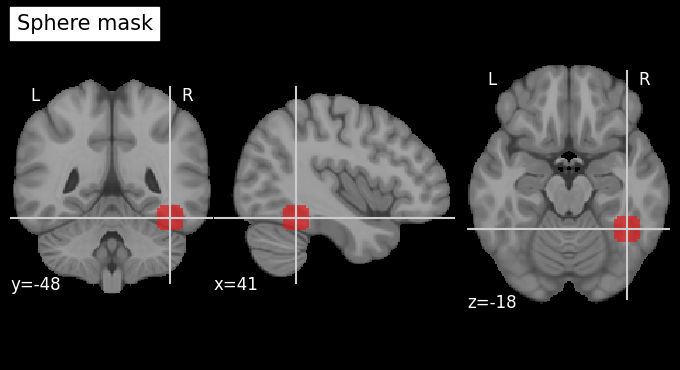

In [5]:
ROI_label = 'Right Fusiform Gyrus'
MNI_coord = (41.5,	-48.5,	-18.5)

# Center voxel in MNI-space
center_voxel = MNI_coord

# Radius in mm
radius = 10

# Define the brain mask
brain_mask_file = layout.get(return_type='file', datatype='func', suffix='mask', desc='brain', space='MNI152NLin2009cAsym', extension='nii.gz')[0]
brain_mask = nibabel.load(brain_mask_file)

# Create the sphere
sphere_mask = create_MNIvoxel_sphere(brain_mask, center_voxel, radius)

# Plot the sphere mask
plot_roi(sphere_mask, bg_img=mni152_template, title='Sphere mask', display_mode='ortho', cmap='Set1')

# Save the sphere mask to a file
sphere_mask_filename = os.path.join(fmri_results_dir,'sphere_mask.nii.gz')
nibabel.save(sphere_mask, sphere_mask_filename)

But this sphere likely includes white matter (and possibly some CSF). If we want the voxels to be responsive to faces, we can further refine the voxels by those that were above some threshold in the faces > scrambled contrast (a "functional" definition) that we created in the second-level, one-sample T-test in the previous notebook:

/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


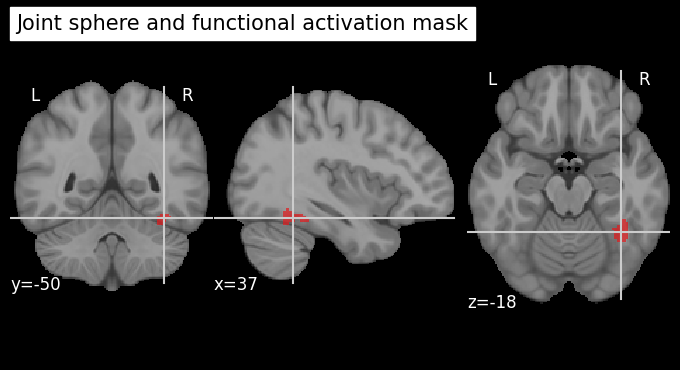

In [6]:
fac_scr_thr = nibabel.load(os.path.join(fmri_results_dir,'group-level','faces-scrambled_Zmap_fdr.nii.gz'))
fac_scr_thr = nilearn.image.binarize_img(fac_scr_thr)

joint_mask  = math_img('(in_sphere * face_responsive)', in_sphere=sphere_mask, face_responsive=fac_scr_thr)
joint_mask_filename = os.path.join(fmri_results_dir,'sphere_and_faces-scrambled_Zmap_fdr.nii.gz')
nibabel.save(joint_mask, joint_mask_filename)
plot_roi(joint_mask, bg_img=mni152_template, title='Joint sphere and functional activation mask', display_mode='ortho', cmap='Set1');

### Extract the mean values from a set of images

Once the spherical ROI is created, we can extract and compute the mean activation values within this ROI across multiple images. Note the ROI and images must be in the same space (e.g., MNI-space here).

In [7]:
def extract_mean_ROI_values(result_files, ROI):
    """
    Extract mean ROI values from a list of results files using a provided ROI mask.

    Parameters:
    - result_files: List of BIDSImageFiles, or a list of file names, containing subject-level results.
    - ROI: Nifti1Image containing the mask data.

    Returns:
    - DataFrame with columns: 'subject', 'condition', 'value'.
    """
    
    # Check if the mask and the file have the same shape (dimensions) and resample if necessary
    first_file = result_files[0]
    if isinstance(first_file, str):
        first_file = layout.get_file(first_file)
    if not ROI.shape == first_file.get_image().shape[:3]:
      ROI = resample_to_img(ROI, first_file.get_image(), interpolation='nearest')
      print(f"Resampled the mask to the shape of result files")
        
    # Initialize an empty list to store the data
    data_list = []

    # Loop through the files and extract the mean ROI values
    for file in result_files:
        # If file is not a BIDSImageFile, but a string, load it
        if isinstance(file, str):
          file = layout.get_file(file)
                 
        # Get the subject ID
        subject = file.get_entities()['subject']
        
        # Get the condition name
        condition = file.get_entities()['desc']
        
        # Get the voxel values within the mask
        img_data = file.get_image()
        mask_data = ROI.get_fdata()
        vox_values = img_data.get_fdata()[mask_data > 0]
        # Compute the mean value
        mean_value = numpy.mean(vox_values)
        
        # Append the data to the list
        data_list.append([subject, condition, mean_value])
    
    # Convert the list to a pandas DataFrame
    data = pandas.DataFrame(data_list, columns=['subject', 'condition', 'value'])
    
    return data

Let's apply the function to extract the mean contrast values within the ROI from each results file. 

In [8]:
data_from_sphere = extract_mean_ROI_values(effect_files, sphere_mask)
print(data_from_sphere)

    subject condition     value
0        01     DelFF  0.229926
1        01     DelSF  0.094739
2        01     DelUF  0.148785
3        01     ImmFF  0.134091
4        01     ImmSF  0.133644
..      ...       ...       ...
139      16     ImmSF  0.027884
140      16     ImmUF  0.054093
141      16     IniFF  0.159801
142      16     IniSF  0.040032
143      16     IniUF  0.088228

[144 rows x 3 columns]


## An anatomical ROI from a probabilistic atlas (amygdala)

In this section, we demonstrate how to create an ROI based on probabilistic data from the [Julich-Brain Cytoarchitectonic Atlas](https://search.kg.ebrains.eu/instances/ab191c17-8cd8-4622-aaac-eee11b2fa670). Probabilistic atlases provide voxel-wise information on the likelihood that a particular brain region corresponds to a given area, reflecting inter-individual variability in brain anatomy or function. The atlas is a single 4D image file, with each ROI stored as a separate volume in the file's fourth dimension. It is accompanied by a label file that indicates which volume corresponds to each region.

You need to download these atlases into the "atlases" directory below, or copy them from the Course Material link provided.

We selected the Julich-Brain Cytoarchitectonic Atlas for this analysis due to its comprehensive coverage of cytoarchitectonic regions, including the amygdala, which is of particular interest in the provided example. The choice of atlas often depends on the specific requirements of the study, such as the need for detailed cytoarchitectonic information or broader anatomical coverage.

Here, we focus on generating an ROI for the amygdala by extracting and combining relevant regions from the atlas, applying a probability threshold, and creating a binary mask for use in subsequent analyses.

We start by specifying the location of the atlas's image and label files, and setting the probability threshold. 

When using probabilistic atlases to define ROIs, **the choice of threshold** can significantly affect the final ROI. The threshold determines the minimum probability that a voxel belongs to a particular region, so a higher threshold will result in a smaller, more conservative ROI, while a lower threshold will include more voxels and create a larger ROI. The choice of threshold depends on your specific research question, the size and function of the region you are studying, and the need for either more inclusive or more conservative ROIs. A moderate threshold (20-30%) is frequently used as a balance between inclusivity and specificity. This threshold will exclude voxels that are less likely to belong to the region while still capturing the bulk of the structure.

It’s advisable to visually inspect the resulting ROIs at different thresholds to ensure they are biologically plausible and appropriate for your analysis.

In [9]:
# Define the location of the atlas and labels files
atlas_julich_file = 'atlases/Julich/JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.pmaps_resized.nii.gz'
labels_julich_file = 'atlases/Julich/JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.txt'

# Set the probability threshold
prob_threshold = 0.25

Next, we identify which volumes in the atlas correspond to the amygdala, our region of interest. We do this by consulting the accompanying label text file, where each ROI in the atlas is assigned a map index. We search for all labels that contain 'amygdala' in their names and extract their map indexes.

In [10]:
# convert labels txt file to dataframe
labels_df = pandas.read_csv(labels_julich_file, sep=" ", quotechar="'", names=['mapindex', 'regionname'], skiprows=1)
print(f"Atlas labels:\n{labels_df}\n----------------------------------")

# find the indexes for regions containing amygdala
mapindex_of_interest = labels_df[labels_df['regionname'].str.contains('Amygdala')].index
print(f"Labels of interest:\n{labels_df.loc[mapindex_of_interest]}\n----------------------------------")

Atlas labels:
     mapindex                            regionname
0           1   Frontal-to-Temporal-I (GapMap) left
1           2  Frontal-to-Temporal-I (GapMap) right
2           3         Ch 123 (Basal Forebrain) left
3           4        Ch 123 (Basal Forebrain) right
4           5           Ch 4 (Basal Forebrain) left
..        ...                                   ...
291       292  Fastigial Nucleus (Cerebellum) right
292       293               CGM (Metathalamus) left
293       294              CGM (Metathalamus) right
294       295               CGL (Metathalamus) left
295       296              CGL (Metathalamus) right

[296 rows x 2 columns]
----------------------------------
Labels of interest:
    mapindex            regionname
6          7    LB (Amygdala) left
7          8   LB (Amygdala) right
8          9    CM (Amygdala) left
9         10   CM (Amygdala) right
10        11    SF (Amygdala) left
11        12   SF (Amygdala) right
12        13   VTM (Amygdala) left
13 

Now we can create a binary mask for the amygdala from probabilistic atlas data, applying a probability threshold to ensure that only regions with sufficient likelihood of corresponding to the amygdala are included in the final mask. We do it in the following steps:

1. Load the 4D atlas image.
2. Extract the specific 3D volumes corresponding to the amygdala.
3. Threshold the selected data to create a binary mask for each 3D volume.
4. Combine these 3D images by summing them.
5. Binarise the combined 3D data to create the final binary mask for the amygdala.
6. Convert the combined data, which is a NumPy array, into a 3D NIfTI image. The affine transformation matrix from the original atlas image is used to ensure the mask aligns correctly in the same spatial orientation as the atlas.

In [11]:
# Load the 4D atlas image
atlas_img = nibabel.load(atlas_julich_file, mmap=True)
atlas_data = atlas_img.get_fdata()

# Select the maps of interest (from the 4th dimension of the 4D image)
selected_data = atlas_data[:, :, :, mapindex_of_interest]

# Threshold the data
thresholded_data = numpy.where(selected_data > prob_threshold, 1, 0)

# Combine these 3D images by summing them
new_3d_data = numpy.sum(thresholded_data, axis=-1)

# Binarize the data
new_3d_data = numpy.where(new_3d_data > 0, 1, 0)

# Cast the data to int8 to avoid compatibility issues
new_3d_data = new_3d_data.astype(numpy.uint8)

# Create a new NIfTI image with the 3D data
amygdala_mask = nibabel.Nifti1Image(new_3d_data, atlas_img.affine) # could set dtype here, but setting it above works better (no warnings)

Now we can plot the created amygdala ROI and save if necessary. 

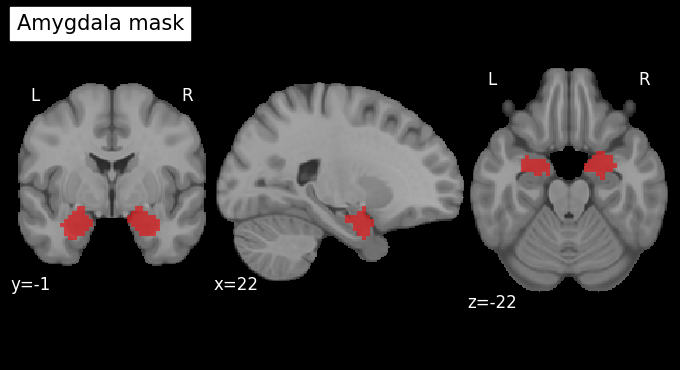

In [12]:
# Plot the amygdala mask
plot_roi(
  amygdala_mask, 
  title='Amygdala mask', 
  display_mode='ortho', 
  draw_cross=False, 
  annotate=True, 
  black_bg=True, 
  bg_img = mni152_template, 
  cmap='Set1')

# Save the mask to a file
nibabel.save(amygdala_mask, os.path.join(fmri_results_dir,'amygdala_mask.nii.gz'))

And once we have the ROI, we can extract the contrast values using the previously created `extract_mean_ROI_values` function.

In [13]:
data_from_amygdala = extract_mean_ROI_values(effect_files, amygdala_mask)
print(data_from_amygdala)

Resampled the mask to the shape of result files
    subject condition     value
0        01     DelFF  0.098270
1        01     DelSF  0.006686
2        01     DelUF  0.061248
3        01     ImmFF  0.030853
4        01     ImmSF  0.048690
..      ...       ...       ...
139      16     ImmSF -0.048642
140      16     ImmUF  0.061118
141      16     IniFF  0.060986
142      16     IniSF  0.006738
143      16     IniUF  0.001149

[144 rows x 3 columns]


An important aspect to note is that the dimensions of the created amygdala ROI differ from those of the results files. For data extraction to occur correctly, the dimensions of the two must match. We have addressed this in our `extract_mean_ROI_values` function. If the ROI's dimensions do not match those of the results file, the ROI is resampled to align with the results file.

In [14]:
# Check the shape of the amygdala mask and the result files
print("Amygdala mask shape:", amygdala_mask.shape[:3])
print("Result files shape:", effect_files[0].get_image().shape[:3])

# Check the voxel dimensions of the amygdala mask
vox_dims = numpy.diag(amygdala_mask.affine)[:3]
print(f"Voxel dimensions of the amygdala mask: {vox_dims}")

# Check the voxel dimensions of the result files
vox_dims = numpy.diag(effect_files[0].get_image().affine)[:3]
print(f"Voxel dimensions of the result files: {vox_dims}")

Amygdala mask shape: (64, 76, 64)
Result files shape: (97, 115, 97)
Voxel dimensions of the amygdala mask: [3. 3. 3.]
Voxel dimensions of the result files: [2. 2. 2.]


## Transforming MNI-space ROI to native-space for native-space analysis

In the final example, we demonstrate how to transform an ROI defined in MNI space (e.g., a spherical mask) into a subject's native space using a transformation matrix derived during preprocessing with fMRIPrep. Once transformed, the ROI can be used to extract activation values from the native-space data of individual subjects. Because the native data have not be resampled/interpolated into MNI space, they will be  (slightly) more accurate than performing the analysis on normalized data. (Better still is to define the ROIs in each subject's native space, which is normally a time-consuming manual process, but might be necessary for small brain nuclei for example.)

In this example, we will use the ANTs Python package [ANTsPy](https://github.com/ANTsX/ANTsPy) to perform the transformation.

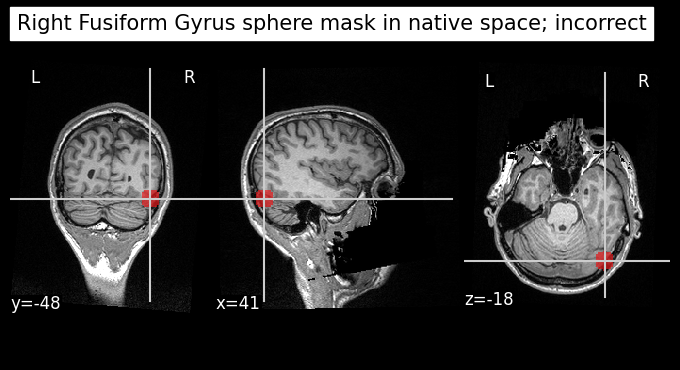

In [15]:
# check the MNI sphere on subject's native space anatomical image
sID = '15'
sub_anat_file = layout.get(subject=sID, datatype='anat', suffix='T1w', extension='nii.gz', desc=None, return_type='file')[0]

plot_roi(sphere_mask, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; incorrect", display_mode='ortho', dim=-1, cmap='Set1');

Found the following transformation file: /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/data/derivatives/fmriprep/sub-15/ses-mri/anat/sub-15_ses-mri_acq-mprage_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5


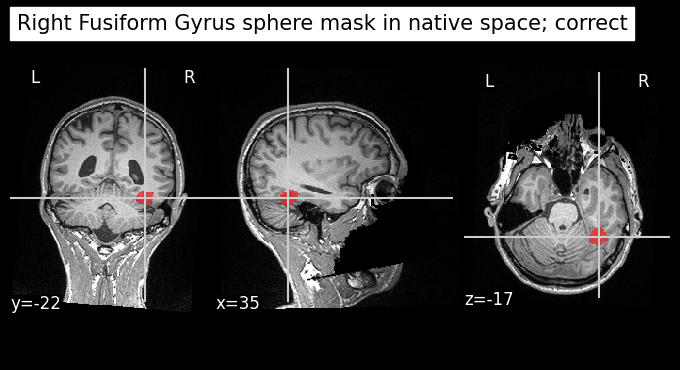

In [16]:
MNI_to_native_xfm_path = layout.get(subject=sID, datatype='anat', extension='h5', to='T1w', return_type='file')[0]
print(f"Found the following transformation file: {MNI_to_native_xfm_path}")

# Apply the transformation to the sphere mask
ROI_native_space = ants.apply_transforms(
  fixed = ants.image_read(sub_anat_file), 
  moving = ants.image_read(sphere_mask_filename),
  transformlist = MNI_to_native_xfm_path, 
  interpolator = 'nearestNeighbor')

# Convert ants image to nibabel image
ROI_native_space = nibabel.Nifti1Image(ROI_native_space.numpy(), nibabel.load(sub_anat_file).affine)

# plot the ROI in native space
plot_roi(ROI_native_space, bg_img=sub_anat_file, title=f"{ROI_label} sphere mask in native space; correct", display_mode='ortho', dim=-1, cmap='Set1')

Importantly, when working in MNI space, a single ROI mask file is sufficient for the entire group since all subjects are aligned to the same space. However, in native space, each subject requires a unique ROI mask due to the individual differences in brain anatomy. As a result, the `extract_mean_ROI_values` function must be applied separately to each subject's results files.

## Statistics and plotting of the ROI data

Now that we have created the ROI masks and extracted the data, we can proceed with statistical analyses as we would with any other dataset. Below are some examples of the ROI analysis results for our example dataset.

### T-test for Familiar vs Unfamiliar Faces in Amygdala

The amygdala may not have been very obvious in the whole-brain analysis we did in the previous notebook. We can gain power by averaging over voxels within an ROI. Let's also average initial and immediate repetitions of famous faces, and of unfamiliar faces:

In [17]:
famous = data_from_amygdala[data_from_amygdala['condition'].isin(['IniFF'])].groupby('subject')['value'].mean()
unfamiliar = data_from_amygdala[data_from_amygdala['condition'].isin(['IniUF'])].groupby('subject')['value'].mean()

# Perform the paired t-test
t_stat, p_value = stats.ttest_rel(famous, unfamiliar, alternative='greater')
print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

Paired t-test results: t-statistic = 2.080819666099899, p-value = 0.027500995375988182


This difference is significant, and to see in which direction (i.e. does amygdala respond more to famous or unknown faces), we can plot the data as below (though one can observe a possible outlier subject who might be driving the effect, and could be worth investigating further):

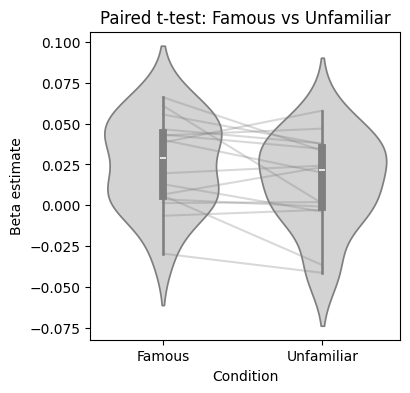

In [18]:
data_famous_unfamiliar = pandas.DataFrame({
    'Condition': ['Famous'] * len(famous) + ['Unfamiliar'] * len(unfamiliar),
    'Value': pandas.concat([famous, unfamiliar]),
    'Subject': list(famous.index) + list(unfamiliar.index)
})

# Adjust the figure size to make it narrower
plt.figure(figsize=(4, 4))  # Reduce the width (first number) to make the plot narrower

# Plot the point plot with dodge to avoid overlap
seaborn.violinplot(x='Condition', y='Value', data=data_famous_unfamiliar, linestyles='-', color='lightgrey')

# Add lines
for subject in data_famous_unfamiliar['Subject'].unique():
    subject_data = data_famous_unfamiliar[data_famous_unfamiliar['Subject'] == subject]
    plt.plot([0, 1], subject_data['Value'], color='gray', alpha=0.3)

plt.ylabel('Beta estimate'); plt.title('Paired t-test: Famous vs Unfamiliar'); plt.show();

### Repeated-measures ANOVA in Right Fusiform ROI

We now return to our functionally-defined, spherical ROI from the peak in right fusiform, which we showed in the previous notebook was more active for faces than scrambled faces. Note that there would be little pointing testing whether faces produce significantly higher activation than scrambled faces in this ROI - this would be double-dipping, ie biased statistics because we have already defined the ROI by the same contrast. However, we can test for orthogonal contrasts, such as whether this region shows repetition effects, or even repetition effects that vary by stimulus-type, because these contrasts are orthogonal to the main effect of faces versus scrambled faces that defined the ROI (orthogonal contrasts are ones whose dot product is zero, where the contrasts themselves are the product of the contrast weights and the regressors; this is true when the dot product of the contrast weights is zero, eg [1 1].[1 -1]' = 0, as is the dot product of the columns of the design matrix on which they apply, which is true for ANOVA models in which each condition is modelled separately, eg [1 0].[0 1]' = 0).

Let's test the 3x2 interaction between stimulus-type (famous, unfamiliar or scrambled faces) and repetition (initial or immediate repeat). We did test this interaction F-contrast across the whole brain in the previous notebook, but nothing survived correction for multiple comparisons. But restricting our analysis to one ROI reduces the correction needed, increasing our power (e.g, we could divide our alpha value by just 2, given that we have tested one contrast for each of two ROIs here: amygdala and fusiform).

First we'll gather the conditions needed for the 3x2 interaction (ie ignoring the delayed repeats).

In [19]:
# drop delayed repeats to emulate contrast in previous notebook
data = data_from_sphere[data_from_sphere['condition'].isin(['IniFF', 'IniUF', 'IniSF', 'ImmFF', 'ImmUF', 'ImmSF'])].copy() 
data = data.sort_values('condition')

# define the 3 levels of the stimulus-type factor
data['stimulus'] = 'famous'
data.loc[data['condition'].isin(['IniUF','ImmUF']), 'stimulus'] = 'unfamiliar'
data.loc[data['condition'].isin(['IniSF','ImmSF']), 'stimulus'] = 'scrambled'

# define the 2 levels of the repetition factor
data['repetition'] = 'initial'
data.loc[data['condition'].isin(['ImmFF', 'ImmUF', 'ImmSF']), 'repetition'] = 'immediate repeat'

print(data)

    subject condition     value    stimulus        repetition
3        01     ImmFF  0.134091      famous  immediate repeat
102      12     ImmFF -0.010871      famous  immediate repeat
129      15     ImmFF  0.163974      famous  immediate repeat
30       04     ImmFF  0.104348      famous  immediate repeat
48       06     ImmFF  0.050479      famous  immediate repeat
..      ...       ...       ...         ...               ...
26       03     IniUF  0.187110  unfamiliar           initial
17       02     IniUF  0.263131  unfamiliar           initial
8        01     IniUF  0.191720  unfamiliar           initial
116      13     IniUF  0.397939  unfamiliar           initial
143      16     IniUF  0.088228  unfamiliar           initial

[96 rows x 5 columns]


In [20]:
# Perform the repeated measures ANOVA
aovrm = AnovaRM(data, depvar='value', subject='subject', within=['stimulus', 'repetition'])
anova_res = aovrm.fit()
print(anova_res)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
stimulus            23.1551 2.0000 30.0000 0.0000
repetition          43.4183 1.0000 15.0000 0.0000
stimulus:repetition  6.7271 2.0000 30.0000 0.0039



This interaction is significant, though again, let's visualise it, this time with a more sophisticated plot: 

#### A 'publication-ready' plot

For the plotting function below, we first create difference scores of immediate repeats minus initial presentations (so-called "repeptition suppression", RS):

In [22]:
# Pivot the DataFrame to wide (to do subtractions) and reset the (subject) index
data = data_from_sphere.copy() 
data_pivot = data.pivot(index='subject', columns='condition', values='value').reset_index()
#print(data_pivot)

# Get the repetition suppression effect for each repetition condition for each subject.
data_pivot['RS_FF'] = data_pivot['ImmFF']-data_pivot['IniFF']
data_pivot['RS_UF'] = data_pivot['ImmUF']-data_pivot['IniUF']
data_pivot['RS_SF'] = data_pivot['ImmSF']-data_pivot['IniSF']

# Reshape the DataFrame to long format
df_rs = data_pivot.melt(id_vars=['subject'], 
                      value_vars=['RS_FF', 'RS_UF', 'RS_SF'], 
                      var_name='condition', 
                      value_name='repetition_effect')

# Redo ANOVA and Tukey T-tests for plotting below
aovrm = AnovaRM(df_rs, depvar='repetition_effect', subject='subject', within=['condition'])
anova_res = aovrm.fit()
#print(anova_res)

The interaction provides evidence that repetition suppression from immediate repetition varies by stimulus-type overall (e.g., appearing smaller for scrambled faces). We could explore further by testing all pairwise comparisons, using for example Tukey's method for correcting for multiple comparions:

In [32]:
tukey_res = pairwise_tukeyhsd(endog=df_rs['repetition_effect'], groups=df_rs['condition'], alpha=0.05)
print(tukey_res) # Tukey’s HSD: This test compares all possible pairs of means and controls the family-wise error rate.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 RS_FF  RS_SF   0.0323  0.307 -0.0204 0.0849  False
 RS_FF  RS_UF  -0.0129 0.8243 -0.0655 0.0398  False
 RS_SF  RS_UF  -0.0452 0.1055 -0.0978 0.0075  False
---------------------------------------------------


However testing all possible pairwise comparisons are rarely appropriate, and here we have planned comparisons of faces vs scrambled and famous vs unfamiliar:

In [40]:
## Planned Comparisons (on repetition effects):
contrasts = numpy.array([[0.5,  0.5, -1.0],    # is repetition effect bigger for faces than scrambled
                         [1.0, -1.0,  0.0]])   # is repetition effect bigger for famous than unfamiliar
dat = data_pivot[list(['RS_FF','RS_UF','RS_SF'])].to_numpy()

for c in range(len(contrasts)):
    contrast_dat = numpy.dot(dat, contrasts[c]) # Multiple data by contrast
    res = stats.ttest_1samp(contrast_dat, 0, alternative='two-sided') # One-sample T-test on result
    print(f"Contrast {str(contrasts[c])}: \tT({res.df})={numpy.round(res.statistic,3)}, p={numpy.round(res.pvalue,3)}")

Contrast [ 0.5  0.5 -1. ]: 	T(15)=-2.96, p=0.01
Contrast [ 1. -1.  0.]: 	T(15)=1.332, p=0.203


Thus we have evidence that repetition suppression (negative values for immediate repetition minus initial presentation) is greater for faces (averaged over famous and unfamiliar) than for scrambled faces.

Here is an example function for plotting a number of effects, together with pairwise differences between them:

In [33]:
def plot_effects(data, subject_col, condition_col, value_col, 
                    anova_results, tukey_results, condition_order, 
                    roi_label='', mni_coord='', title='', xlabel='', ylabel='', xticks=[]):
    """
    Plots the results of a 1-by-3 ANOVA with within-subject 95% confidence intervals and significance annotations.
    
    Parameters:
    - data: DataFrame containing the data (long format).
    - subject_col: Name of the column representing subjects.
    - condition_col: Name of the column representing the condition.
    - value_col: Name of the column representing the dependent variable.
    - anova_results: ANOVA results object containing F and p values.
    - tukey_results: Tukey's HSD test results containing p-values.
    - condition_order: List specifying the order of conditions.
    - roi_label: Label for the region of interest (ROI).
    - mni_coord: MNI coordinates as a string.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - xticks: List of custom x-axis labels.
    - title: Title for the plot.
    
    Returns:
    - A plot of the ANOVA results with error bars and significance markers.
    """
    # Get the ANOVA F-value and p-value for the plot title
    F_value = anova_results.anova_table['F Value'].iloc[0]
    
    if anova_results.anova_table['Pr > F'].iloc[0] < 0.001:
        p_value = "< 0.001"
    else:
        p_value = f"= {anova_results.anova_table['Pr > F'].iloc[0]:.3f}"

    # Determine the significance markers for the pairs based on the Tukey's HSD test
    annotations = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.' for p in tukey_results.pvalues]
    
    # Look in Tukey's results for the order of the pairs to know which pairs corresponds to which p-value
    pairs = [(2, 1), (2, 0), (1, 0)]  
    
    # Ensure 'subject' and 'condition' are categorical variables
    data[subject_col] = data[subject_col].astype('category')
    data[condition_col] = data[condition_col].astype('category')
    
    # Calculate the mean for each condition
    means = data.groupby(condition_col, observed=True)[value_col].mean()
    
    # Subtract the participant's mean value from each score to calculate deviations
    data['deviation'] = data[value_col] - data.groupby(subject_col, observed=True)[value_col].transform('mean')
    
    # Calculate the standard error of the mean for each condition
    sem = data.groupby(condition_col, observed=True)['deviation'].std() / numpy.sqrt(data[subject_col].nunique())
    
    # Calculate the t-value for the 95% confidence interval
    t_value = stats.t.ppf(1 - 0.025, data[subject_col].nunique() - 1)  # degrees of freedom = n-1
    
    # Calculate the confidence interval
    ci = sem * t_value
    
    # Plot the data
    plt.figure(figsize=(6, 8))
    
    # Create a point plot
    seaborn.pointplot(data=data, x=condition_col, y=value_col, order=condition_order, capsize=.1, errorbar=None, color='black', markers='o', linestyles='-', estimator=numpy.mean)
    
    # Add error bars using the calculated within-subject CI
    plt.errorbar(x=range(len(means)), y=means[condition_order], yerr=ci[condition_order], fmt='none', capsize=5, color='black')
    
    # Add individual data points
    seaborn.stripplot(data=data, x=condition_col, y=value_col, order=condition_order, color='grey', alpha=0.6, jitter=True)
    
    # Annotate the plot with significance markers
    y_max = data[value_col].max() + (data[value_col].max() * 0.01)  # Position above the highest point
    y_range = data[value_col].max() + (data[value_col].max() * 0.02)  # Adjust the range to avoid overlapping
    
    for i, (pair, annotation) in enumerate(zip(pairs, annotations)):
        x1, x2 = pair
        y = y_max + (i * 0.02)  # Space annotations vertically
        plt.plot([x1, x2], [y, y], color='black', lw=1.5)
        plt.text((x1 + x2) * 0.5, y + 0.002, annotation, ha='center', va='bottom', color='black')
    
    # Add horizontal line at 0
    plt.axhline(y=0, color='grey')
    
    # Remove plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Remove tick marks but keep the labels
    plt.tick_params(axis='both', which='both', length=0)  
    
    # Add labels and title
    plt.xlabel(f'\n{xlabel}')
    plt.ylabel(ylabel)
    
    # Custom x labels
    plt.xticks(ticks=range(len(means)), labels=xticks)
    
    # Set title
    plt.title(f"{title} \n F = {F_value:.2f}, p {p_value}; error bars: within-subj 95% CI")
    
    # Show plot
    plt.show()

We can now call it to plot the three repetition effects in our ROI:

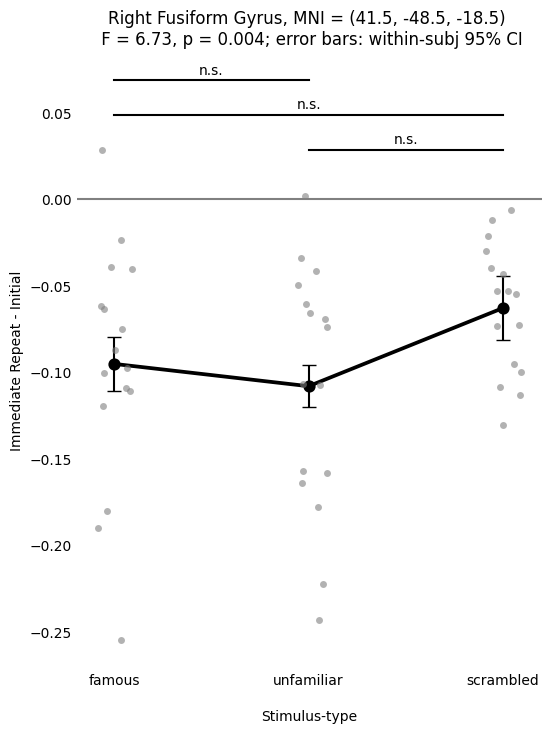

In [34]:
plot_effects(
    data=df_rs,
    subject_col='subject',
    condition_col='condition',
    value_col='repetition_effect',
    anova_results=anova_res,
    tukey_results=tukey_res,
    condition_order=['RS_FF', 'RS_UF', 'RS_SF'],
    roi_label=ROI_label,
    mni_coord=MNI_coord,
    xlabel='Stimulus-type',
    ylabel='Immediate Repeat - Initial', 
    xticks=['famous', 'unfamiliar', 'scrambled'], 
    title=f"{ROI_label}, MNI = {MNI_coord}"
)

Thus the general pattern for the significant interaction is greater repetition suppression for faces than scrambled faces in this ROI. Note that we are not making any scientific claims about this - it is just for demonstration purposes!